In [187]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [188]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()


(184, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [189]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

#encoding a 5x5 matrix as a 25x1 vector
def encode(pose):
    [row,col] = pose
    state_num = row * 5 + col
    return state_num

def decode(state_num):
    row = state_num // 5
    col = state_num % 5
    return row, col

print(R,G,B,Y)

[0, 0] [0, 4] [4, 0] [4, 3]


In [190]:
curr_state = get_state(env.s)
print("Taxi at",curr_state)
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)

Taxi at [1 4 1 0]


In [191]:
def choose_action(state,qs,eps):
    #print(np.shape(q))
    length = np.shape(qs)[1]
    if not qs[state].any():
        return random.randint(0,length-1)
    action = np.argmax(qs[state])
    
    if np.random.rand() < eps:
        action = np.random.randint(0,length-1)
        return action
    return action   

def choose_action_option(state,qs):
    action = np.argmax(qs[state])
    return action  

In [192]:
# Options where policy is greedy wrt the corresponding q Value function
def Red(q_r,state,eps):
    optdone = False
    optact = choose_action(state,q_r,eps)
    state = decode(state)
    if state[0] == R[0] and state[1] == R[1]:
        optdone = True
    return optact,optdone

def Green(q_g,state,eps):
    optdone = False
    optact = choose_action(state,q_g,eps)
    state = decode(state)
    if state[0] == G[0] and state[1] == G[1]:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state,eps):
    optdone = False
    optact = choose_action(state,q_y,eps)
    state = decode(state)
    if state[0] == Y[0] and state[1] == Y[1]:
        optdone = True
    return optact,optdone 

def Blue(q_b,state,eps):
    optdone = False
    optact = choose_action(state,q_b,eps)
    state = decode(state)
    if state[0] == B[0] and state[1] == B[1]:
        optdone = True
    return optact,optdone 

In [203]:
Q_opt = np.zeros((4,25,4))
q = np.zeros((500,10))
qf = np.zeros((500,10))
qof = np.zeros((4,25,4))

### Hardcoded policy

In [194]:
q = np.zeros((500,10))
qf = np.zeros((500,10))
Q_opt = np.zeros((4,25,4))
qof = np.zeros((4,25,4))

policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ]).flatten()
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ]).flatten()
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ]).flatten()
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ]).flatten()

policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]
for index1, value1 in enumerate(policyOpt):
   for index2, value2  in enumerate(value1):
      Q_opt[index1][index2][value2] = 1
#print(Q_opt)


### SMDP

In [204]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA1 = 0.1
ALPHA2 = 0.01
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [205]:
class SMDP:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def Qlearn(self):
        for episode in range(3000):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                epsilon = 0.15
                action = choose_action(state,q,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q[state,action] = q[state, action] + ALPHA1 * (reward + GAMMA * np.max(q[next_state, :])- q[state, action])
                    qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 
                    epsilon = 0.1
                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA2 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA2* (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        if optdone == True:
                            q[current_state, action] += ALPHA1 * (reward_bar - q[current_state, action] + (GAMMA**count) * np.max(q[next_state, :]))
                            state = env.s
                        
            running = 0.05 * ep_reward + (1 - 0.05) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=0.71, color='blue')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break



    def plot_optionsQ(self,k):
        Q = np.flipud(Q_opt[k].reshape(5,5,4))
        plt.figure(figsize=(5,5))
        ACTIONS = {0:"R",1: "G",2: "Y", 3: "B"}
        plt.pcolor(qof[k].reshape(5,5,4).max(-1), edgecolors='k', linewidths=2)
        plt.title(ACTIONS[k])
        plt.colorbar()
        def x_direct(a):
            if a in [1, 0]:
                return 0
            return 1 if a == 2 else -1
        def y_direct(a):
            if a in [2, 3]:
                return 0
            return 1 if a == 1 else -1
        policy = Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        plt.savefig('world_' + ACTIONS[k] + '_Q_plot.png')
        plt.show()
        

Working

Episode 1: Total Reward = -317.6
Episode 2: Total Reward = -22.200000000000003
Episode 3: Total Reward = -512.85
Episode 4: Total Reward = -410.05
Episode 5: Total Reward = -110.0
Episode 6: Total Reward = -39.75
Episode 7: Total Reward = -39.45
Episode 8: Total Reward = -115.75
Episode 9: Total Reward = -269.0
Episode 10: Total Reward = -63.400000000000006
Episode 11: Total Reward = -247.35000000000002
Episode 12: Total Reward = -172.45000000000002
Episode 13: Total Reward = -32.15
Episode 14: Total Reward = -150.75
Episode 15: Total Reward = -268.3
Episode 16: Total Reward = -159.9
Episode 17: Total Reward = -5.9
Episode 18: Total Reward = -29.650000000000002
Episode 19: Total Reward = -280.65000000000003
Episode 20: Total Reward = -375.90000000000003
Episode 21: Total Reward = -69.10000000000001
Episode 22: Total Reward = -180.85000000000002
Episode 23: Total Reward = -209.05
Episode 24: Total Reward = -17.25
Episode 25: Total Reward = -166.25
Episode 26: Total Reward = -32.85
Episo

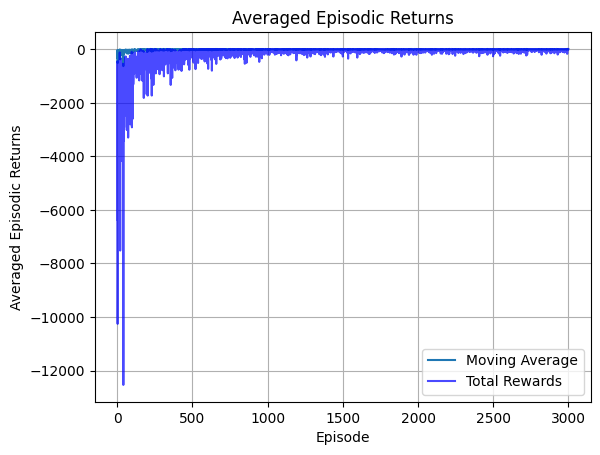

In [206]:
smdp = SMDP()
smdp.Qlearn()
smdp.plot()

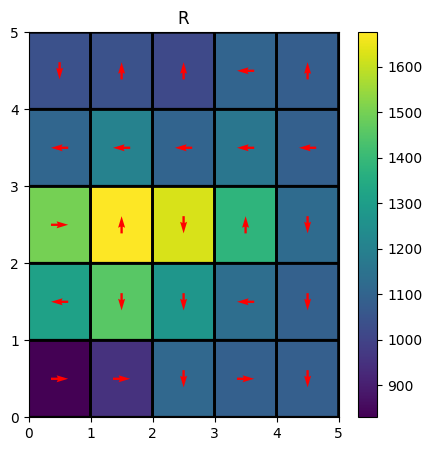

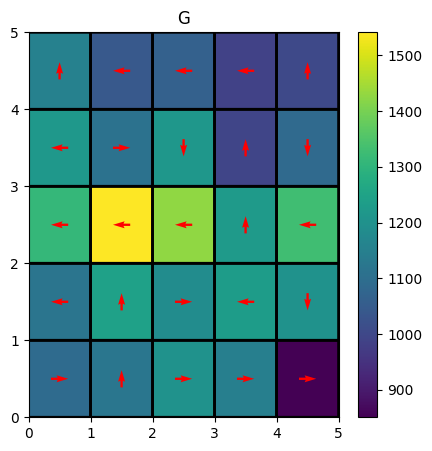

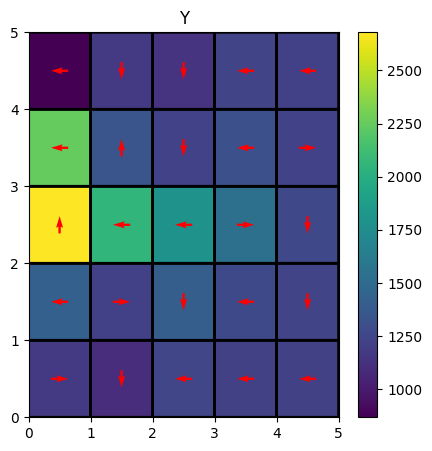

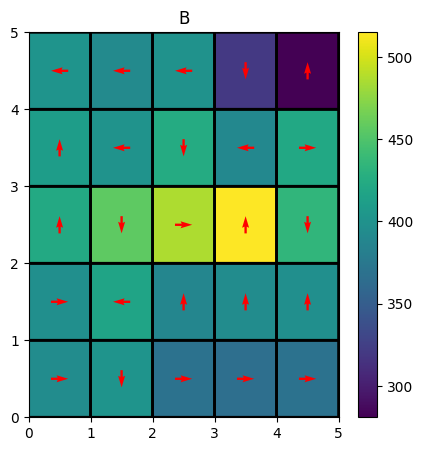

In [207]:
smdp.plot_optionsQ(0)
smdp.plot_optionsQ(1)
smdp.plot_optionsQ(2)
smdp.plot_optionsQ(3) 


### INTRA OPTION

In [199]:
q_intra = np.zeros((500,10))
qf = np.zeros((500,10))
qof = np.zeros((4,25,4))

In [200]:
class INTRAOPT:
    def __init__(self):
        self.avg_reward = []
        self.total_reward = []

    def Qlearn(self):
        epsilon = 0.1
        for episode in range(5000):
            running = 0
            state, _ = env.reset()
            done = False
            ep_reward = 0
            steps = 0

            while not done :
                steps += 1
                state = env.s
                action = choose_action(state,q_intra,epsilon)
                if action < 6:
                    next_state, reward, done, _, _ = env.step(action)
                    ep_reward += reward
                    q_intra[state,action] = q_intra[state, action] + ALPHA1 * (reward + GAMMA * np.max(q_intra[next_state, :])- q_intra[state, action])
                    qf[state,action] += 1
                    state = next_state
                
                reward_bar = 0
                if action > 5 :
                    count = 0
                    
                    optdone = False
                    current_state = state
                    state = encode(get_state(state)[0:2]) 

                    while (optdone == False) :
                        if action == 6:
                            optact, optdone = Red(Q_opt[0],state,epsilon) 
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[0][state,optact] = Q_opt[0][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[0][next, :])- Q_opt[0][state, optact])
                            qof[0][state,optact] += 1

                        if action == 7:
                            optact, optdone = Green(Q_opt[1],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[1][state,optact] = Q_opt[1][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[1][next, :])- Q_opt[1][state, optact])
                            qof[1][state,optact] += 1

                        if action == 8:
                            optact, optdone = Blue(Q_opt[2],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[2][state,optact] = Q_opt[2][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[2][next, :])- Q_opt[2][state, optact])
                            qof[2][state,optact] += 1

                        if action == 9:

                            optact, optdone = Yellow(Q_opt[3],state,epsilon)
                            next_state, reward, done, _, _ = env.step(optact)
                            next = encode(get_state(next_state)[0:2])
                            Q_opt[3][state,optact] = Q_opt[3][state, optact] + ALPHA1 * (reward + GAMMA * np.max(Q_opt[3][next])- Q_opt[3][state, optact])
                            qof[3][state,optact] += 1

                        reward_bar =  reward_bar + (GAMMA**count)*reward
                        ep_reward += reward
                        count += 1
                        state = next
                        statey = env.s
                        q_intra[statey, action] += ALPHA1 * (reward_bar - q_intra[statey, action] + (GAMMA**count) * np.max(q_intra[statey, :]))
                        
                        
                if epsilon > 0.01:
                    epsilon = epsilon*np.exp(-0.01)
            running = 0.35 * ep_reward + (1 - 0.35) * running
            self.avg_reward.append(running)
            self.total_reward.append(ep_reward)
            print(f"Episode {episode + 1}: Total Reward = {running}")
        return self.avg_reward, self.total_reward
    
    def plot(self):
        plt.plot(self.avg_reward,label="Moving Average")
        plt.grid()
        plt.plot(self.total_reward,label="Total Rewards",alpha=1, color='orange')
        plt.xlabel('Episode')
        plt.ylabel('Averaged Episodic Returns')
        plt.title("Averaged Episodic Returns")
        plt.legend()
        plt.savefig('SMDP.png')
        plt.show()

    def render_run(self):
        special_env = gym.make('Taxi-v3',render_mode='human')
        done = False
        eps = 0.01
        state, _ = special_env.reset()
        while not done:
            action = choose_action(state,q,eps)
            next_state, reward, done, _, _ = special_env.step(action)
            if done:
                break

    def plot_Q(self):
        ACTIONS = {0: "South",1: "Up",2: "East",3: "West",4: "Pick",5: "Drop",6: "R",7: "G",8: "B", 9: "Y"}
        # decode each state 
        # ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
        action = np.argmax(q,axis=1)
        action_f = np.argmax(qf,axis=1)

        dest_r = action[::4]
        dest_g = action[1::4]
        dest_b = action[2::4]
        dest_y = action[3::4]

        dest_r_f = action_f[::4]
        dest_g_f = action_f[1::4]
        dest_b_f = action_f[2::4]
        dest_y_f = action_f[3::4]

        loc_r_r = dest_r[::5]
        loc_r_g = dest_g[::5]
        loc_r_b = dest_b[::5]
        loc_r_y = dest_y[::5]

        loc_r_r_f = dest_r_f[::5]
        loc_r_g_f = dest_g_f[::5]
        loc_r_b_f = dest_b_f[::5]
        loc_r_y_f = dest_y_f[::5]

        loc_g_r = dest_r[1::5]
        loc_g_g = dest_g[1::5]
        loc_g_b = dest_b[1::5]
        loc_g_y = dest_y[1::5]

        loc_g_r_f = dest_r_f[1::5]
        loc_g_g_f = dest_g_f[1::5]
        loc_g_b_f = dest_b_f[1::5]
        loc_g_y_f = dest_y_f[1::5]

        loc_b_r = dest_r[2::5]
        loc_b_g = dest_g[2::5]
        loc_b_b = dest_b[2::5]
        loc_b_y = dest_y[2::5]

        loc_b_r_f = dest_r_f[2::5]
        loc_b_g_f = dest_g_f[2::5]
        loc_b_b_f = dest_b_f[2::5]
        loc_b_y_f = dest_y_f[2::5]

        loc_y_r = dest_r[3::5]
        loc_y_g = dest_g[3::5]
        loc_y_b = dest_b[3::5]
        loc_y_y = dest_y[3::5]

        loc_y_r_f = dest_r_f[3::5]
        loc_y_g_f = dest_g_f[3::5]
        loc_y_b_f = dest_b_f[3::5]
        loc_y_y_f = dest_y_f[3::5]

        action_o = np.argmax(Q_opt,axis=2)
        action_o_f = np.argmax(qof,axis=2)

        dest_r = action_o[0]
        dest_g = action_o[1]
        dest_b = action_o[2]
        dest_y = action_o[3]

        freq_r = action_o_f[0]
        freq_g = action_o_f[1]
        freq_b = action_o_f[2]
        freq_y = action_o_f[3]

        # Create a 5x5 grid for grid and frequncy
        grid = np.reshape(loc_r_g, (5, 5))
        freq = np.reshape(loc_r_g_f, (5, 5))

        # Create a 5x5 grid for grid and frequncy
        grid_dest = np.reshape(dest_r, (5, 5))
        freq_dest = np.reshape(freq_r, (5, 5))

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display the grid with numbers for loc_r_g
        axs[0].imshow(freq, cmap='viridis', interpolation='nearest')
        for i in range(5):
            for j in range(5):
                text = ACTIONS[grid[i, j]]
                axs[0].text(j, i, text, ha='center', va='center', color='black')

        # Add labels and title for loc_r_g
        axs[0].set_title("Red passenger to dest Green q table")
        axs[0].set_xlabel('Column')
        axs[0].set_ylabel('Row')

        # Display the grid with numbers for dest_r
        axs[1].imshow(freq_dest, cmap='viridis', interpolation='nearest')
        for i in range(5):
            for j in range(5):
                text = ACTIONS[grid_dest[i, j]]
                axs[1].text(j, i, text, ha='center', va='center', color='black')

        # Add labels and title for dest_r
        axs[1].set_title("Red Option Policy")
        axs[1].set_xlabel('Column')
        axs[1].set_ylabel('Row')

        plt.tight_layout()
        plt.show()
        
        
    

Episode 1: Total Reward = -1421.35
Episode 2: Total Reward = -690.55
Episode 3: Total Reward = -754.5999999999999
Episode 4: Total Reward = -902.9999999999999
Episode 5: Total Reward = -287.34999999999997
Episode 6: Total Reward = -1335.25
Episode 7: Total Reward = -92.75
Episode 8: Total Reward = -920.15
Episode 9: Total Reward = -64.75
Episode 10: Total Reward = -236.24999999999997
Episode 11: Total Reward = -375.2
Episode 12: Total Reward = -219.45
Episode 13: Total Reward = -341.95
Episode 14: Total Reward = -284.2
Episode 15: Total Reward = -579.9499999999999
Episode 16: Total Reward = -399.7
Episode 17: Total Reward = -227.49999999999997
Episode 18: Total Reward = -141.39999999999998
Episode 19: Total Reward = -318.5
Episode 20: Total Reward = -944.3
Episode 21: Total Reward = -106.39999999999999
Episode 22: Total Reward = -154.7
Episode 23: Total Reward = -349.29999999999995
Episode 24: Total Reward = -136.85
Episode 25: Total Reward = -177.45
Episode 26: Total Reward = -164.85


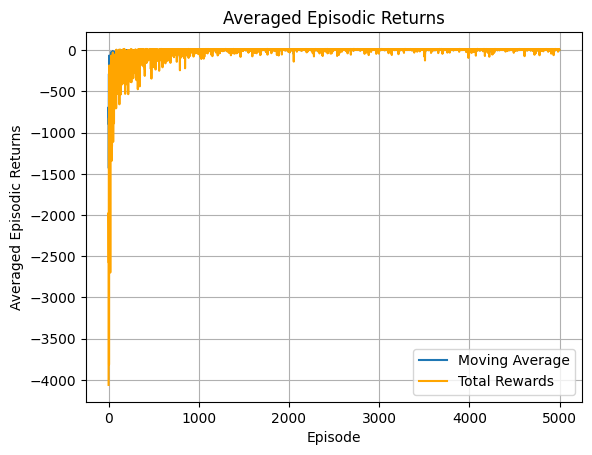

In [201]:
agent2 = INTRAOPT()
agent2.Qlearn()
agent2.plot()

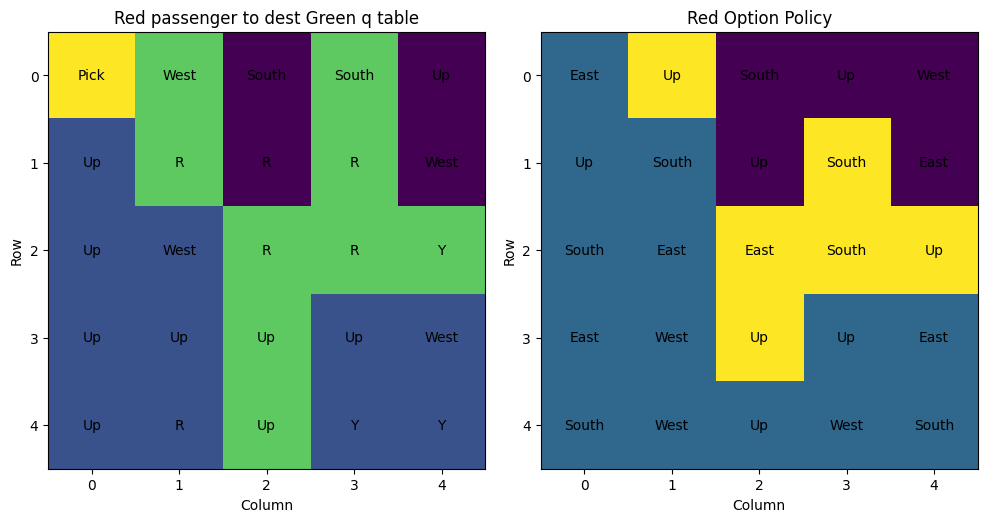

In [202]:
agent2.plot_Q()